This example uses a dataset called CIFAR10. It has 10 classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.  

The goal is to train a classifier that can predict the labels of those images with an accuracy better than chance (10%). The final test accuracy of the network is 94.65%.

In [1]:
import os
import sys
import time
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnchoredOffsetbox
from tqdm import tqdm # progress bar

sys.path.append('../../../src')

## some parameters

In [2]:
batch_size = 128
learning_rate = 0.1
epochs = 180

## only use dataset and dataloader from pytorch
tensors loaded using `pytorch` will be converted to `tortto` tensors later.

In [3]:
from numpy.random import choice
from torch.utils.data import DataLoader, random_split, Subset
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, RandomCrop, RandomHorizontalFlip, ToTensor, Normalize

In [4]:
dataset_path = '../../cifar10_data'
img_mean = (0.49139968, 0.48215841, 0.44653091)
img_sd = (0.24703223, 0.24348513, 0.26158784)
transform_aug = Compose([
    RandomCrop(32, padding=4),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(img_mean, img_sd),
])
transform = Compose([
    ToTensor(),
    Normalize(img_mean, img_sd)
])
# create datasets
train_dataset = CIFAR10(root=dataset_path, train=True, download=True, transform=transform_aug)
val_dataset = CIFAR10(root=dataset_path, train=True, download=True, transform=transform)
test_dataset = CIFAR10(root=dataset_path, train=False, download=True, transform=transform)

# create dataloaders
indices = choice(50_000, size=50_000, replace=False)
train_idx, val_idx = indices[:45_000], indices[45_000:]
train_loader = DataLoader(Subset(train_dataset, train_idx), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(Subset(val_dataset, val_idx), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print('size of train set', len(train_idx))
print('size of validation set', len(val_idx))
print('size of test set', len(test_dataset))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
size of train set 45000
size of validation set 5000
size of test set 10000


## the rest is done in pytortto

In [5]:
import tortto as tt
import tortto.nn as nn
import tortto.nn.functional as F
import tortto.optim as optim

## define a network

In [6]:
def conv3x3(in_channels, channels, stride=1):
    return nn.Conv2d(in_channels, channels, kernel_size=3, stride=stride, padding=1, bias=False)
def conv1x1(in_channels, channels, stride=1):
    return nn.Conv2d(in_channels, channels, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion=1
    def __init__(self, in_channels, channels, stride=1, downsample=nn.Sequential()):
        """
        in_channels: number of incoming channels.
        channels: number of channels in the first layer of this block
        """
        super(BasicBlock, self).__init__()
        self.act=nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU()
        )
        self.residual=nn.Sequential(
            conv3x3(in_channels, channels, stride),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            conv3x3(channels, channels)
        )
        self.downsample = downsample


    def forward(self,x):
        out = self.act(x)
        shortcut = self.downsample(x)
        out = self.residual(out)
        return out + shortcut


class PreactResNet(nn.Module):
    def __init__(self, block, layers, channels, num_classes):
        """
        layers: number of residual blocks in each layer
        channels: number of channels
        """
        super(PreactResNet, self).__init__()
        self.in_channels=channels[0]
        self.conv1 = conv3x3(3, self.in_channels)
        self.layer1 = self._make_layer(block, channels[0], layers[0])
        self.layer2 = self._make_layer(block, channels[1], layers[1], stride=2)
        self.layer3 = self._make_layer(block, channels[2], layers[2], stride=2)
        self.layer4 = self._make_layer(block, channels[3], layers[3], stride=2)
        self.bn = nn.BatchNorm2d(self.in_channels) # in_channels will increase accordingly after each _make_layer call
        self.relu = nn.ReLU()
        self.fc = nn.Sequential(
            nn.Linear(self.in_channels, num_classes),
            nn.LogSoftmax(dim=-1)
        )

    def _make_layer(self, block, channels, blocks, stride=1):
        downsample = nn.Sequential()
        # for the first block of conv2_x, if bottleneck is used, there will be increase of channels
        # so we need downsample
        if stride != 1 or self.in_channels != channels * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.in_channels, channels * block.expansion, stride)
            )

        # append the first block in the layer
        layers = [block(self.in_channels, channels, stride, downsample)]
        self.in_channels = channels * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(self.in_channels, channels) # stride=1
            )
        return nn.Sequential(*layers)

    def forward(self,x):
        x = self.conv1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.bn(x)
        x = self.relu(x)

        x = tt.mean(x,(-1,-2),True)
        x = tt.flatten(x, 1)
        x = self.fc(x)

        return x

def preact_resnet18(num_classes=10):
    return PreactResNet(BasicBlock, [2,2,2,2], [64,128,256,512], num_classes)

In [7]:
net = preact_resnet18().cuda()
criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
print(f'total trainable parameters: {sum(_.numel() for _ in net.parameters())/1e6:.2f} million')

total trainable parameters: 11.17 million


## define functions for training and validation

In [8]:
def calculate_loss(batch, correct, total):
    inputs, labels = batch
    
    # convert pytorch tensor to tortto tensor
    inpt = tt.tensor(inputs.numpy()).cuda()
    lab = tt.tensor(labels.numpy()).cuda()
    
    # forward
    outputs = net(inpt)
    loss = criterion(outputs, lab)
    
    # prediction
    predicted = outputs.argmax(-1)
    correct += (predicted == lab).sum().item()
    total += lab.shape[0]
    
    return loss, correct, total
    
    
def train():
    # train
    net.train()
    correct = 0
    total = 0
    loop = tqdm(train_loader)
    train_loss = 0
    for i, batch in enumerate(loop):

        # zero the parameter gradients
        optimizer.zero_grad()

        loss, correct, total = calculate_loss(batch, correct, total)
        
        # accumulate loss
        train_loss += loss.item()

        # backpropagation
        loss.backward()

        # update parameters
        optimizer.step()

    # keep track of train loss and train error
    loss_history['train'].append(train_loss / (i + 1))
    error_history['train'].append(100 * (1. - correct / total))
    

@tt.no_grad()
def val_test(dataloader):
    net.eval()
    correct = 0
    total_sample = 0
    total_loss = 0
    loop = tqdm(dataloader)
    for i, batch in enumerate(loop):
        
        # cal loss
        loss, correct, total_sample = calculate_loss(batch, correct, total_sample)
        
        # accumulate val loss
        total_loss += loss.item()
    
    avg_loss = total_loss / (i + 1)
    avg_error = 100 * (1. - correct / total_sample)
    return avg_loss, avg_error

    
def save():
    global lowest_error
    # save checkpoint
    if epoch > 120 and error_history['val'][-1] < lowest_error:
        checkpoint = {
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'train_idx': train_idx,
            'val_idx': val_idx
            }
        tt.save(checkpoint, f'models/checkpoint_{str(epoch).zfill(3)}.npy')
        lowest_error = error_history['val'][-1]
    
    # save loss, error history and log
    tt.save(loss_history, 'logs/loss_history.npy')
    tt.save(error_history, 'logs/error_history.npy')
    with open('logs/log.txt','a') as f:
        f.write('epoch{} finished at {}. val_loss: {:.4f} - val_error: {:.2f}%\n'.
                format(str(epoch).zfill(3), 
                       datetime.now().strftime("%m/%d/%Y, %H:%M:%S"), 
                       loss_history['val'][-1], 
                       error_history['val'][-1]))

## start training
This cell is empty because Jupyter notebook can't run in google cloud while hang up. Codes are copied to a .py file and use `nohup` command to train.  
The best model, error and loss history are recorded.

In [ ]:
loss_history = {'train': [], 'val': []}
error_history = {'train': [], 'val': []}

if os.path.exists('logs/log.txt'):
    raise OSError('Previous training logs already exist.')

lowest_error = 100
warmup=1
for epoch in range(epochs):
    if epoch < warmup:
        optimizer.param_groups[0]['lr'] = learning_rate / 10
    elif epoch == warmup:
        optimizer.param_groups[0]['lr'] = learning_rate
    
    # train
    train()
    
    # validation
    val_loss, val_error = val_test(val_loader)
    loss_history['val'].append(val_loss)
    error_history['val'].append(val_error)
    print(' - val_loss: {:.4f} - val_error: {:.2f}%\n'.format(loss_history['val'][-1], val_error))
    
    # save
    save()
    
    # step scheduler
    scheduler.step()

## plot loss and error

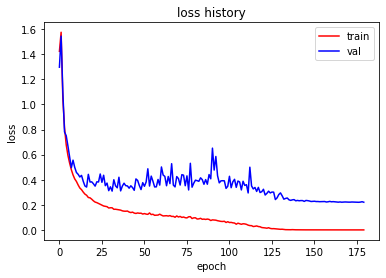

In [9]:
loss_history = tt.load('logs/loss_history.npy')
plt.plot(loss_history['train'], 'r', label='train')
plt.plot(loss_history['val'], 'b', label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss history')
plt.legend()
plt.show()

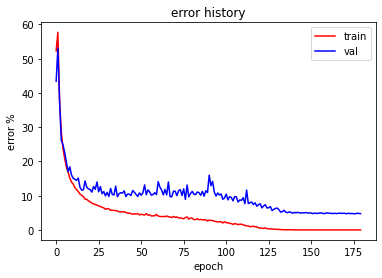

In [10]:
error_history = tt.load('logs/error_history.npy')
plt.plot(error_history['train'], 'r', label='train')
plt.plot(error_history['val'], 'b', label='val')
plt.xlabel('epoch')
plt.ylabel('error %')
plt.title('error history')
plt.legend()
plt.show()

## evaluation on test set

In [11]:
# load checkpoint with the lowest validation error
checkpoint = tt.load('models/checkpoint_176.npy')
net.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [12]:
_, test_error = val_test(test_loader)
print(f'Test error: {test_error:.2f}%')

100%|██████████| 79/79 [00:09<00:00,  8.19it/s]

Test error: 5.35%


## plot predictions along with probabilities

In [ ]:
# https://stackoverflow.com/questions/44550764/how-can-i-embed-an-image-on-each-of-my-subplots-in-matplotlib
def place_image(im, loc=3, ax=None, zoom=1, **kw):
    if ax == None: ax = plt.gca()
    imagebox = OffsetImage(im, zoom=zoom)
    ab = AnchoredOffsetbox(loc=loc, child=imagebox, frameon=False, **kw)
    ax.add_artist(ab)


inputs, labels = next(iter(test_loader))
inpt = tt.tensor(inputs.numpy()).cuda()
lab = tt.tensor(labels.numpy()).cuda()
with tt.no_grad():
    outputs = net(inpt)
predicted = outputs.argmax(-1)

images = inpt.moveaxis(-3, -1).cpu().numpy()
prob = outputs.exp().detach().cpu().numpy()
fig, axs = plt.subplots(4, 4, figsize=(12, 15))
fig.tight_layout()
plt.subplots_adjust(top=1)
figure_loc = {_: 'upper left' for _ in range(16)}
for n in (0, 3, 6, 8, 9, 10):
    figure_loc[n] = 'upper right'

for n, ax in enumerate(axs.flat):
    ax.bar(classes, prob[n])
    ax.tick_params('x', labelrotation=45)
    ax.set_ylim([0, 1.1])
    ax.set_aspect(10)
    ax.set_title(f'pred:{classes[predicted[n].item()]} | Truth:{classes[lab[n].item()]}')

    place_image((img_sd * images[n] + img_mean).clip(0,1), loc=figure_loc[n], ax=ax, pad=0, zoom=2.5)